# RUL Transformer
This notebook creates a Transformer model for RUL prediction of the N-CMAPSS dataset.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import DataUtils
import Masking

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# device = 'cpu'

In [4]:
batch_size = 64
trainloader, testloader = DataUtils.get_ncmapss_dataloaders(1, n_timesteps=10, batch=batch_size, workers=8, subsampled=True)

In [5]:
columns_excluded = [0, 1, 26] # make sure to mask and THEN take these out
columns_kept = [False, False, True, True, True,
               True, True, True, True, True,
               True, True, True, True, True,
               True, True, True, True, True,
               True, True, True, True, True,
               True, False]
print(columns_kept)

[False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False]


In [6]:
example = next(enumerate(trainloader))
ex_X = example[1][0]
print(ex_X.shape)

ex_y = example[1][1]
print(ex_y.shape)

torch.Size([64, 10, 46])
torch.Size([64, 1])


In [5]:
class RULTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.prediction_window = 1
        self.input_len = 10
        self.n_cols = 46
        self.embed_dim = 64
        
        self.input_projection = nn.Linear(self.input_len*self.n_cols, self.embed_dim)
        self.positional_embed = nn.Parameter(torch.randn(self.embed_dim))
        
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=self.embed_dim, nhead=4, activation="gelu", dim_feedforward=64)
        self.transformer_blocks = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        
        self.rul_head = nn.Sequential(nn.Linear(self.embed_dim, self.prediction_window))
    
    def forward(self, x):
        
        x = x.flatten(1)
        z = self.input_projection(x)
        z = z + self.positional_embed
        z = self.transformer_blocks(z)
        z = self.rul_head(z)
        
        return z.squeeze(1)

In [8]:
rul_tran = RULTransformer()

In [9]:
rul_tran(ex_X.float())

tensor([-0.4472, -0.3985, -0.3515, -0.3901, -0.2955, -0.2242, -0.3861, -0.4155,
        -0.4682, -0.3920, -0.2255, -0.4870, -0.3851, -0.2682, -0.3574, -0.4148,
        -0.3692, -0.1118, -0.3044, -0.2802, -0.5408, -0.3495, -0.3517, -0.3521,
        -0.3579, -0.2588, -0.2237, -0.1317, -0.2619, -0.2920, -0.1600, -0.1680,
        -0.3918, -0.3307, -0.3485, -0.1730, -0.2138, -0.4006, -0.1840, -0.3173,
        -0.1684, -0.3315, -0.4576, -0.1380, -0.2029, -0.4816, -0.3712, -0.4955,
        -0.2887, -0.2744, -0.2358, -0.5322, -0.3465, -0.2795, -0.4180, -0.2545,
        -0.4554, -0.4819, -0.2694, -0.1531, -0.2915, -0.3198, -0.3499, -0.1726],
       grad_fn=<SqueezeBackward1>)

In [6]:
objective = nn.MSELoss()

rul_tran = RULTransformer().to(device)

lr = 1e-4
n_epochs = 1000
optim = torch.optim.Adam(rul_tran.parameters(), lr=lr)
losses = []

for n in range(n_epochs):
    counter = 0
    for i, (X, y) in enumerate(tqdm(trainloader)):
        X = X.to(device)
        y = y.to(device)
        optim.zero_grad()
        yhat = rul_tran(X.float())
        loss = objective(yhat, y.float().squeeze(1))
        loss.backward()
        losses.append(loss.cpu().detach().numpy())
        optim.step()
        counter += 1
        
    print("Epoch:", n+1, "Loss:",np.mean(losses[-counter:][0]))

  1%|██▎                                                                                                                                                                        | 527/38334 [00:16<20:11, 31.22it/s]


KeyboardInterrupt: 

In [8]:
import cProfile

def profiled_code():
    batch_size = 128
    trainloader, testloader = DataUtils.get_ncmapss_dataloaders(1, n_timesteps=10, batch=batch_size, workers=10)
    
    objective = nn.MSELoss()

    rul_tran = RULTransformer().to(device)

    lr = 1e-4
    n_epochs = 1
    optim = torch.optim.Adam(rul_tran.parameters(), lr=lr)
    losses = []

    for n in range(n_epochs):
        counter = 0
        for i, (X, y) in enumerate(tqdm(trainloader)):
            X = X.to(device)
            y = y.to(device)
            optim.zero_grad()
            yhat = rul_tran(X)
            loss = objective(yhat, y.squeeze(1))
            loss.backward()
            losses.append(loss.cpu().detach().numpy())
            optim.step()
            counter += 1

        print("Epoch:", n+1, "Loss:",np.mean(losses[-counter:][0]))
        
cProfile.run('profiled_code()', sort='time')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38334/38334 [20:07<00:00, 31.74it/s]

Epoch: 1 Loss: 2544.2205
         59064350 function calls (58488536 primitive calls) in 1207.735 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    38344  498.468    0.013  498.468    0.013 {method 'poll' of 'select.poll' objects}
    38334  386.961    0.010  386.961    0.010 {method 'run_backward' of 'torch._C._EngineBase' objects}
   536676   51.282    0.000   51.282    0.000 {built-in method posix.read}
    38334   22.226    0.001   64.147    0.002 adam.py:300(_single_tensor_adam)
    76668   20.055    0.000   20.055    0.000 {method 'recvmsg' of '_socket.socket' objects}
   306672   19.731    0.000   19.731    0.000 {built-in method torch._C._nn.linear}
    38334   14.279    0.000   14.279    0.000 {built-in method torch._C._nn.scaled_dot_product_attention}
  1303356   11.827    0.000   11.827    0.000 {method 'mul_' of 'torch._C._TensorBase' objects}
        1   10.777   10.777 1207.703 1207.703 2501959424.py:3(profil

In [15]:
test_mses = []
yhats = []
ys = []
with torch.no_grad():
    for i, (X, y) in enumerate(tqdm(testloader)):
            yhat = rul_tran(X[:,:,columns_kept].float())
            yhats.append(yhat.values)
            ys.append(y)
            test_mse = objective(yhat, y.float())
            test_mses.append(test_mse.item())
print("Test MSE:", np.mean(test_mses))

100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:50<00:00,  4.04it/s]

Test MSE: 3225.7484491953037


In [23]:
yhats[0]

tensor([210.9679, 194.1083, 217.5564, 207.1253, 204.0876, 225.3761, 238.6421,
        211.9415, 232.4276, 216.7056, 214.0647, 203.5335, 197.0618, 201.2545,
        196.0110, 197.8357, 179.1796, 179.7321, 195.9025, 183.6204, 183.0923,
        178.7597, 170.3666, 177.8416, 167.1471, 168.2934, 168.8532, 176.5083,
        157.2803, 155.9755, 152.4332, 225.9115, 208.0154, 202.5079, 189.9653,
        190.8138, 195.0503, 181.0711, 167.8269, 168.5141, 163.0723, 171.4613,
        177.1479, 172.3226, 181.6575, 173.2844, 182.9755, 172.3159, 179.1907,
        187.5553, 179.6185, 179.1948, 183.3639, 176.9701, 170.3868, 173.9801,
        159.2134, 158.2923, 158.6102, 157.9540, 169.1164, 167.9136, 170.6057,
        164.4907])

C:\Users\austi\miniconda3\envs\deep_learn\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
C:\Users\austi\miniconda3\envs\deep_learn\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: only one element tensors can be converted to Python scalars

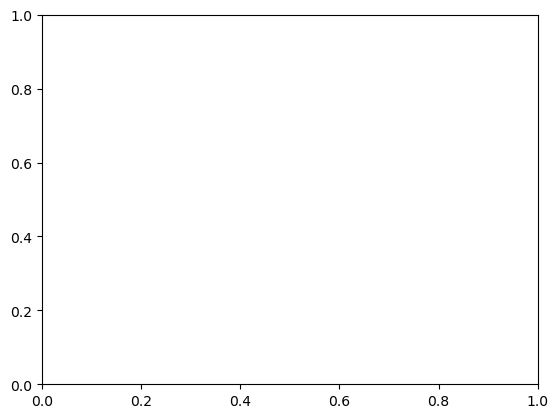

In [16]:
plt.plot(yhats)
pl.plot(ys)

In [13]:
np.sqrt(3226)

56.79788728465171

### Saving the Model

In [10]:
torch.save(rul_tran.state_dict(), './saved_models/rul_transformer_prototype_nomask.pt')